In [1]:
import os
import pandas as pd
import seaborn as sns
import similarity_index as similarity_index
from scipy import stats
import statsmodels as sms

In [2]:
OUT_DIR = "outputs_new"
XL_PATH = r"inputs/radiomicsFeatures.csv"

In [3]:
num_repeats = 100

feats_df = pd.read_csv(XL_PATH)

In [4]:
stability_df = {"fs_method":[], "similarity_measure":[], "top_k":[], "estimate":[]}

fs_methods = ["random", "oneDSAE", "bayesianDSAE", "ensembleDSAE", "backwardSFS/LogisticRegression", "backwardSFS/SVC", "backwardSFS/RandomForestClassifier", "backwardSFS/MLPClassifier"]
similarity_methods = {"jaccard":similarity_index.jaccard, "dice":similarity_index.dice, "kuncheva":similarity_index.kuncheva, "mwm":similarity_index.mwm}
top_ks = [5, 10, 15, 20, 25]


for fs_method in fs_methods:

    for i in range(num_repeats):
    
        for j in range(i+1, num_repeats):
    
            df1 = pd.read_csv(os.path.join(OUT_DIR, fs_method, f"rank_df{i}.csv"))
            df2 = pd.read_csv(os.path.join(OUT_DIR, fs_method, f"rank_df{j}.csv"))

            for similarity_measure, similarity_fn in similarity_methods.items():

                for k in top_ks:

                    estimate = similarity_fn(df1=df1, df2=df2, k=k, feats_df = feats_df)

                    stability_df["fs_method"].append(fs_method)
                    stability_df["similarity_measure"].append(similarity_measure)
                    stability_df["top_k"].append(k)
                    stability_df["estimate"].append(estimate)

                
            estimate = similarity_index.global_spearman(df1, df2)

            stability_df["fs_method"].append(fs_method)
            stability_df["similarity_measure"].append("global_spearman")
            stability_df["top_k"].append("NA")
            stability_df["estimate"].append(estimate)

In [5]:
stability_df = pd.DataFrame(stability_df)

In [6]:
mean_stability_df = stability_df.groupby(by=["fs_method", "similarity_measure", "top_k"]).mean()

In [10]:
mean_stability_df

estimate
fs_method                      similarity_measure top_k          
backwardSFS/LogisticRegression dice               5      0.169293
                                                  10     0.230687
                                                  15     0.289549
                                                  20     0.343545
                                                  25     0.389495
...                                                           ...
random                         mwm                5      0.351689
                                                  10     0.452002
                                                  15     0.519344
                                                  20     0.572751
                                                  25     0.614868

[168 rows x 1 columns]

In [17]:
mean_stability_df.loc['backwardSFS/RandomForestClassifier']

estimate
similarity_measure top_k          
dice               5      0.159273
                   10     0.196889
                   15     0.236525
                   20     0.273556
                   25     0.318263
global_spearman    NA     0.053957
jaccard            5      0.094759
                   10     0.113614
                   15     0.137424
                   20     0.161239
                   25     0.191762
kuncheva           5      0.109229
                   10     0.095229
                   15     0.081767
                   20     0.062992
                   25     0.051959
mwm                5      0.431644
                   10     0.503181
                   15     0.553708
                   20     0.592807
                   25     0.628811

In [20]:
mean_stability_df.loc['oneDSAE']

estimate
similarity_measure top_k          
dice               5      0.300121
                   10     0.428121
                   15     0.496013
                   20     0.536596
                   25     0.559337
global_spearman    NA     0.445395
jaccard            5      0.197330
                   10     0.290660
                   15     0.347345
                   20     0.381873
                   25     0.399259
kuncheva           5      0.258462
                   10     0.355731
                   15     0.393854
                   20     0.402276
                   25     0.387204
mwm                5      0.534125
                   10     0.622866
                   15     0.670356
                   20     0.695869
                   25     0.714673

In [ ]:
stability_df.to_csv(os.path.join(OUT_DIR, "stability_df.csv"), index=False)

### Selected Feature Overlap

In [94]:
import numpy as np

In [101]:
topk_count = {}

topk_df = {}

num_repeats = 100

fs_methods = ["random", "oneDSAE", "bayesianDSAE", "ensembleDSAE", "backwardSFS/LogisticRegression", "backwardSFS/SVC", "backwardSFS/RandomForestClassifier", "backwardSFS/MLPClassifier"]

k = 5

for fs_method in fs_methods:

    topk_count[fs_method] = {}

    for i in range(num_repeats):
    
        df = pd.read_csv(os.path.join(OUT_DIR, fs_method, f"rank_df{i}.csv"))
    
        feats = df.sort_values(by="rank")["feature"].to_list()[:k]

        for feat in feats:

            topk_count[fs_method][feat] = topk_count[fs_method].get(feat, 0) + 1


for fs_method in fs_methods:

    feats, counts = zip(*topk_count[fs_method].items())

    topk_df[fs_method] = pd.DataFrame({"feats":feats, "counts":counts})
    

    

  

In [102]:
set(topk_df["oneDSAE"].sort_values(by="counts", ascending=False).feats.to_list()[:6])&set(topk_df["bayesianDSAE"].sort_values(by="counts", ascending=False).feats.to_list()[:6])&set(topk_df["ensembleDSAE"].sort_values(by="counts", ascending=False).feats.to_list()[:6])

{'adc_original_glszm_SizeZoneNonUniformityNormalized',
 'sub_win_original_glszm_SizeZoneNonUniformityNormalized',
 'sub_wout_original_firstorder_Uniformity',
 'sub_wout_original_glcm_JointEntropy',
 't2w_original_glrlm_RunEntropy',
 't2w_original_glszm_SizeZoneNonUniformityNormalized'}

In [103]:
set(topk_df["backwardSFS/LogisticRegression"].sort_values(by="counts", ascending=False).feats.to_list()[:6])&set(topk_df["backwardSFS/SVC"].sort_values(by="counts", ascending=False).feats.to_list()[:6])&set(topk_df["backwardSFS/RandomForestClassifier"].sort_values(by="counts", ascending=False).feats.to_list()[:6])&set(topk_df["backwardSFS/MLPClassifier"].sort_values(by="counts", ascending=False).feats.to_list()[:6])

set()

In [106]:
set(topk_df["backwardSFS/LogisticRegression"].sort_values(by="counts", ascending=False).feats.to_list()[:6])&set(topk_df["backwardSFS/SVC"].sort_values(by="counts", ascending=False).feats.to_list()[:6])

{'sub_win_original_firstorder_10Percentile',
 'sub_win_original_firstorder_90Percentile',
 'sub_wout_original_glcm_SumEntropy',
 'sub_wout_original_glszm_SmallAreaHighGrayLevelEmphasis',
 't2w_original_glcm_ClusterTendency'}

In [105]:
set(topk_df["backwardSFS/RandomForestClassifier"].sort_values(by="counts", ascending=False).feats.to_list()[:6])&set(topk_df["backwardSFS/MLPClassifier"].sort_values(by="counts", ascending=False).feats.to_list()[:6])

set()

### Statistical Analysis (Wilcoxon Signed Rank Test)

##### <> 1. SFS+LR v/s Ensemble AE
- global, and Kuncheva Top-5

In [ ]:
similarity_measure="global_spearman"
top_k = "NA"

In [ ]:
x = stability_df[(stability_df.fs_method=="backwardSFS/LogisticRegression")&(stability_df.similarity_measure==similarity_measure)&(stability_df.top_k==top_k)].estimate.to_list()
y = stability_df[(stability_df.fs_method=="random")&(stability_df.similarity_measure==similarity_measure)&(stability_df.top_k==top_k)].estimate.to_list()

sns_data = pd.DataFrame({"LR":x, "ensembleAE":y})
sns.boxplot(data=sns_data)

print("Wilcoxon Signed Rank Test: p-value = ", stats.wilcoxon(x, y).pvalue)

print("Paired T-Test: ", "normality, x-", stats.shapiro(x).pvalue, ",y-", stats.shapiro(y).pvalue, "ttest-", stats.ttest_rel(x, y).pvalue)

In [109]:
similarity_measure="mwm"
top_k = 5

Wilcoxon Signed Rank Test: p-value =  0.0
Paired T-Test:  normality, x- 8.102549139448015e-21 ,y- 2.3948798131244453e-13 ttest- 0.0


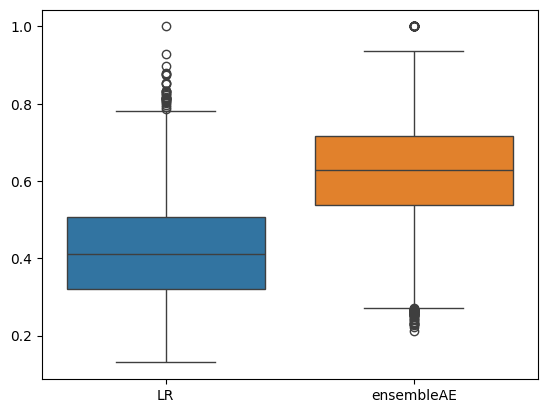

In [110]:
x = stability_df[(stability_df.fs_method=="backwardSFS/LogisticRegression")&(stability_df.similarity_measure==similarity_measure)&(stability_df.top_k==top_k)].estimate.to_list()
y = stability_df[(stability_df.fs_method=="ensembleDSAE")&(stability_df.similarity_measure==similarity_measure)&(stability_df.top_k==top_k)].estimate.to_list()

sns_data = pd.DataFrame({"LR":x, "ensembleAE":y})
sns.boxplot(data=sns_data)

print("Wilcoxon Signed Rank Test: p-value = ", stats.wilcoxon(x, y).pvalue)

print("Paired T-Test: ", "normality, x-", stats.shapiro(x).pvalue, ",y-", stats.shapiro(y).pvalue, "ttest-", stats.ttest_rel(x, y).pvalue)

##### <> 1. bayesian AE v/s Ensemble AE
- global, and Kuncheva Top-5

In [ ]:
similarity_measure="global_spearman"
top_k = "NA"

In [ ]:
x = stability_df[(stability_df.fs_method=="bayesianDSAE")&(stability_df.similarity_measure==similarity_measure)&(stability_df.top_k==top_k)].estimate.to_list()
y = stability_df[(stability_df.fs_method=="ensembleDSAE")&(stability_df.similarity_measure==similarity_measure)&(stability_df.top_k==top_k)].estimate.to_list()

sns_data = pd.DataFrame({"bayesianAE":x, "ensembleAE":y})
sns.boxplot(data=sns_data)

print("Wilcoxon Signed Rank Test: p-value = ", stats.wilcoxon(x, y).pvalue)

print("Paired T-Test: ", "normality, x-", stats.shapiro(x).pvalue, ",y-", stats.shapiro(y).pvalue, "ttest-", stats.ttest_rel(x, y).pvalue)

In [ ]:
similarity_measure="mwm"
top_k = 5

In [ ]:
x = stability_df[(stability_df.fs_method=="bayesianDSAE")&(stability_df.similarity_measure==similarity_measure)&(stability_df.top_k==top_k)].estimate.to_list()
y = stability_df[(stability_df.fs_method=="ensembleDSAE")&(stability_df.similarity_measure==similarity_measure)&(stability_df.top_k==top_k)].estimate.to_list()

sns_data = pd.DataFrame({"LR":x, "ensembleAE":y})
sns.boxplot(data=sns_data)

print("Wilcoxon Signed Rank Test: p-value = ", stats.wilcoxon(x, y).pvalue)

print("Paired T-Test: ", "normality, x-", stats.shapiro(x).pvalue, ",y-", stats.shapiro(y).pvalue, "ttest-", stats.ttest_rel(x, y).pvalue)

### Complexity Analysis

In [ ]:
DATA_DIR = r"outputs"
FS_METHODS = ["backwardSFS", "oneDSAE", "bayesianDSAE", "ensembleDSAE"]

In [ ]:
sfs_results_df = pd.read_csv(os.path.join(DATA_DIR, "backwardSFS/results_df.csv"), index_col=0)
sAE_results_df = pd.read_csv(os.path.join(DATA_DIR, "oneDSAE", "results_df.csv"))
bAE_results_df = pd.read_csv(os.path.join(DATA_DIR, "bayesianDSAE", "results_df.csv"))
eAE_results_df = pd.read_csv(os.path.join(DATA_DIR, "ensembleDSAE", "results_df.csv"))

In [ ]:
time_df = {"fs_method":[], "# runs":[], "exe_time":[]}

In [ ]:
sAE_time_df = pd.DataFrame({"# runs":sAE_results_df.groupby(["outer_seed"]).first().index.to_numpy(), "exe_time":sAE_results_df.groupby(["outer_seed"]).first()["exe_time"].to_numpy()})
time_df["fs_method"] += ['singleAE'] * len(sAE_time_df)
time_df["# runs"] += list(sAE_time_df["# runs"].to_numpy() + 1)
time_df["exe_time"] += list(sAE_time_df["exe_time"].to_numpy())

bAE_time_df = pd.DataFrame({"# runs":bAE_results_df.groupby(["outer_seed"]).first().index.to_numpy(), "exe_time":bAE_results_df.groupby(["outer_seed"]).first()["exe_time"].to_numpy()})
time_df["fs_method"] += ['bayesianAE'] * len(bAE_time_df)
time_df["# runs"] += list(bAE_time_df["# runs"].to_numpy() + 1)
time_df["exe_time"] += list(bAE_time_df["exe_time"].to_numpy())

eAE_time_df = pd.DataFrame({"# runs":eAE_results_df.groupby(["outer_seed", "b"]).first().groupby("outer_seed").sum().index.to_numpy(), "exe_time":eAE_results_df.groupby(["outer_seed", "b"]).first().groupby("outer_seed").sum()["exe_time"].to_numpy()})
time_df["fs_method"] += ['ensembleAE'] * len(eAE_time_df)
time_df["# runs"] += list(eAE_time_df["# runs"].to_numpy()+1)
time_df["exe_time"] += list(eAE_time_df["exe_time"].to_numpy())

In [ ]:
def acronym(estimator):

    acronym = ""
    
    if estimator=="LogisticRegression":
        acronym = "SFS+LR"
    elif estimator=="SVC":
        acronym = "SFS+L-SVM"
    elif estimator=="RandomForestClassifier":
        acronym = "SFS+RF"
    elif estimator=="MLPClassifier":
        acronym = "SFS+MLP"
    else:
        print("Invalid estimator name")

    return acronym

In [ ]:


for estimator in ["LogisticRegression", "SVC", "RandomForestClassifier", "MLPClassifier"]:

    _df = sfs_results_df.groupby(["estimator","outer_seed"]).sum().loc[estimator]
    sfs_time_df = pd.DataFrame({"# runs":_df.index.to_numpy()+1, "exe_time":_df["exe_time"].to_numpy()})

    time_df["fs_method"] += [acronym(estimator)] * len(sfs_time_df)
    time_df["# runs"] += list(sfs_time_df["# runs"].to_numpy()+1)
    time_df["exe_time"] += list(sfs_time_df["exe_time"].to_numpy())


    

In [ ]:
time_df = pd.DataFrame(time_df)
time_df["cumulative_exe_time"] = time_df.groupby('fs_method')['exe_time'].cumsum()

display(time_df)

In [ ]:
time_df['exe_time (mins)'] = time_df['exe_time']/60
time_df['cumulative_exe_time (mins)'] = time_df['cumulative_exe_time']/60

In [ ]:
time_df

In [ ]:
sns.boxplot(data=time_df, x='exe_time (mins)', y='fs_method', width=.2, fill=False, color=".1")

In [ ]:
# sns.barplot(data=time_df, x='cumulative_exe_time', y='fs_method', width=.2, fill=False, color=".4")
# sns.boxplot(data=time_df, x='exe_time', y='fs_method', width=.2, fill=False, color=".4")
sns.barplot(data=time_df, x='cumulative_exe_time (mins)', y='fs_method', width=.2, fill=False, color=".1", errorbar=None)